In [1]:
# buffer size for coloring algorithm
# recommend running this on m5.4xlarge (ubuntu, 60gb, 32 cpus)
edgebufsz = 64 * 1024 * 1024
nthreads = 32

from absl import app, flags
import sys, os

import numpy as np
import pandas as pd
import scipy.sparse as sps
import warnings
import sys
import os
from functools import partial

from tqdm.notebook import tqdm

In [2]:
%%bash

if ! [ -d url_svmlight ] ; then
    wget --quiet "http://www.sysnet.ucsd.edu/projects/url/url_svmlight.tar.gz"
    tar xzf url_svmlight.tar.gz
fi

if ! [ -f parallelSort.o ] || ! [ -f u4_sort.so ] || ! [ -f u8_sort.so ]; then
    ./build.sh
fip = 

In [14]:
from utils_graph_coloring import *

import random
np.random.seed(1234)
random.seed(1234)

Xcontinuous, Xcsr, Xcsc, y, nrows, ncols = get_all_data()

print('extraced feature summary')
print('nrows', nrows, 'ncols', ncols)
print('continuous', Xcontinuous.shape[1], 'binary', Xcsc.shape[1])
print()
print('label breakdown')
print(pd.Series(y).value_counts() / nrows)
print()
print('non-null values per column (categorical only)')
nnzc = np.diff(Xcsc.indptr)
print(pd.Series(nnzc).describe().to_frame().transpose())
print()
print('non-null values per row (categorical only)')
nnzr = np.diff(Xcsr.indptr)
print(pd.Series(nnzr).describe().to_frame().transpose())
print()
print('sparsity among categorical {:.3g}'.format(Xcsc.getnnz() / np.prod(Xcsc.shape)))

extraced feature summary
nrows 2396130 ncols 3381409
continuous 64 binary 3381345

label breakdown
0.0    0.669407
1.0    0.330593
dtype: float64

non-null values per column (categorical only)
       count       mean          std  min  25%  50%  75%        max
0  3381345.0  60.770149  9048.536248  0.0  1.0  2.0  3.0  2396130.0

non-null values per row (categorical only)
       count       mean        std   min   25%   50%   75%    max
0  2396130.0  85.756966  15.102465  14.0  76.0  83.0  94.0  381.0

sparsity among categorical 2.54e-05


In [4]:
### Create the set of co-occurence edges
#
# pack an edge into a single u64. Everything here and below needs to be re-done
# for every training fold, but we do it once on the whole dataset for
# debugging / illustrative purposes.
#
# notably, this is 'static' coloring where you know the vertex count
# ahead of time, so this accepts train indices and looks up Xbinary_csr directly.
def coloring_prep(train, Xbinary_csr, nthreads, edgebufsz):
    with timeit('dropping non-train features'):
        csc_train = Xbinary_csr[train].tocsc()
        csc_train.eliminate_zeros()
        dead_features = np.diff(csc_train.indptr) == 0
        num_dead = dead_features.sum()
        Xbinary_csr = Xbinary_csr[:, ~dead_features].copy()
    print('dropped', num_dead, 'dead features')
    Xbinary_csr.eliminate_zeros()
    nnzr = np.diff(Xbinary_csr.indptr)
    with timeit('creating graph'):
        # TODO: could sumbsample here for speed
        Xtrain_csr_color = Xbinary_csr[train]
        final_edgeset_u64 = create_edgeset_u64(Xtrain_csr_color, edgebufsz, tqdm=tqdm, nthreads=nthreads)
    nverts = Xbinary_csr.shape[1] # includes vacuous 0 column
    nedges = len(final_edgeset_u64)
    print('nverts         {:>15,}'.format(nverts))
    print('nedges         {:>15,}'.format(nedges))
    print('degree         {:>15.0f}'.format(nedges / nverts))
    print('graph sparsity {:>15.3e}'.format(
        nedges / (nverts * (nverts - 1) // 2)))

    # add an extra slot so that later after cumsum
    # degree[-2] to degree[-1] defines the range for
    degree = np.zeros(int(nverts + 1), dtype=np.uint32)
    bidir_edges = np.zeros(nedges * 2, np.uint32)

    with timeit('bidirectional edges'):
        count_degree(final_edgeset_u64, degree[1:])
        vertex_offsets = np.cumsum(degree, dtype=np.uint64)
        fill_edges(final_edgeset_u64, bidir_edges, vertex_offsets.copy(), vertex_offsets)

    with timeit('color'):
        # will segfault if >2**16 colors
        ncolors, color_map = color_graph(degree[1:], bidir_edges, vertex_offsets)
    print('colors', ncolors)

    with timeit('color remap'):
        # if we got a 'color collision', then last write wins
        # one of the indices will get saved, the other won't.
        Xcategorical_color, color_cards = color_remap(Xbinary_csr, ncolors, color_map, nnzr)

    return Xcategorical_color, color_cards

In [5]:
%%time
ixs = np.arange(nrows, dtype=int)
# malicious urls is temporally correlated, only 1 split to make
cut = int(.7 * nrows)
train_ixs, test_ixs = ixs[:cut], ixs[cut:]

set_parallelism(nthreads)
Xcolor, cardinalities = coloring_prep(train_ixs, Xcsr, nthreads, edgebufsz)

     dropping non-train features  ...took       4.01 sec 
dropped 673653 dead features
                  creating graph


  ...took      26.53 sec 
nverts               2,707,692
nedges             259,136,336
degree                      96
graph sparsity       7.069e-05
             bidirectional edges  ...took      13.99 sec 
                           color  ...took       2.42 sec 
colors 465
                     color remap  ...took      24.59 sec 
CPU times: user 10min 17s, sys: 3min 4s, total: 13min 21s
Wall time: 1min 11s


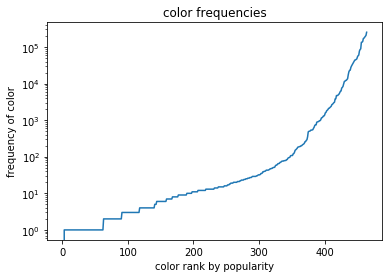

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.semilogy(list(sorted(cardinalities)))
cardinalities
plt.xlabel('color rank by popularity')
plt.ylabel('frequency of color')
plt.title('color frequencies')
plt.show()

In [7]:
import lightgbm as lgb
import warnings

def eval_lgbm(X, y):
    
    with timeit('data prep'):
        Xdense, Xmaybe_sparse = X
        if sps.issparse(Xmaybe_sparse):
            X = sps.hstack(X, 'csr', np.float32)
        else:
            X = np.asarray(np.hstack(X).astype(np.float32))
        cats = [i + Xdense.shape[1] for i in range(Xmaybe_sparse.shape[1])]
        dataset = lgb.Dataset(data=X[train_ixs], label=y[train_ixs], params={'verbose': -1})
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message='Using categorical_feature in Dataset.')
        warnings.filterwarnings("ignore", message='.*categorical_feature in Dataset is overridden.*')
        with timeit('training'):
            gbm = lgb.train(
                params = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'num_threads': nthreads,
                    'verbose': -1,
                    'metric': 'binary_logloss'},
                train_set=dataset,                
                verbose_eval=False,
                categorical_feature=cats)
        with timeit('prediction'):
            out = gbm.predict(X[test_ixs], verbose_eval=False)
        print('final acc {:.3%}'.format(((out >= 0.5) == y[test_ixs]).mean()))

In [8]:
# use LGBM online exclusive feature bundling (EFB), which does coloring automatically
# for us!
eval_lgbm((Xcontinuous, Xcsr), y)

                       data prep  ...took       8.74 sec 
                        training  ...took      37.16 sec 
                      prediction  ...took       1.89 sec 
final acc 98.735%


In [9]:
# collapse with graph coloring before training
# note coloring probably took 90 seconds altogether
# if you used 32 threads
eval_lgbm((Xcontinuous, Xcolor), y)

                       data prep  ...took       6.26 sec 
                        training  ...took      21.65 sec 
                      prediction  ...took       0.89 sec 
final acc 99.018%


In [10]:
import xgboost as xgb
def eval_xgb(X, y, nnzc):
    # NOTE: target encoding isn't quite as powerful as LGBM's EFB,
    # but for non-categorical classifiers it gets the job done!
    encoder = TargetEncoder(cards=nnzc, is_sparse=sps.issparse(X[1]), debug=False)
    
    with timeit('data prep'):
        Xtrain = tuple(x[train_ixs] for x in X)
        Xtest = tuple(x[test_ixs] for x in X)
        
        
        Xtrain = encoder.fit_transform(Xtrain, y.astype(float))
        Xtest = encoder.transform(Xtest)
        dtrain = xgb.DMatrix(Xtrain, label=y[train_ixs])
        dtest = xgb.DMatrix(Xtest, label=y[test_ixs])

    param = {
        'objective': 'binary:logistic'}
    
    num_round = 100
    with timeit('train'):
        bst = xgb.train(param, dtrain, num_round)
    with timeit('prediction'):
        preds = bst.predict(dtest, ntree_limit=num_round)
        
    print('final acc {:.3%}'.format(((preds >= 0.5) == y[test_ixs]).mean()))

In [11]:
# note the ~75 seconds for coloring on train should
# count here too
eval_xgb((Xcontinuous, Xcolor), y, cardinalities)

                       data prep  ...took      24.18 sec 
                           train  ...took     127.86 sec 
                      prediction  ...took       0.21 sec 
final acc 98.833%


array([0.9992793 , 0.00164915, 0.9989536 , ..., 0.10557781, 0.00291084,
       0.00431713], dtype=float32)

In [16]:
eval_xgb((Xcontinuous, Xcsc.astype(np.uint32)), y, nnzc)

                       data prep  ...took      91.06 sec 
                           train  ...took     235.72 sec 
                      prediction  ...took       1.27 sec 
final acc 98.882%


array([0.99981517, 0.00371897, 0.9997081 , ..., 0.9848166 , 0.00448632,
       0.00240642], dtype=float32)